# Let's start with langgraph

In [1]:
from langgraph.graph import StateGraph, START, END

# Let's define a node

In [ ]:
def node_1(state):
    return {"message": " james!"}

# Let's define a State

In [5]:
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: str

# Let's build our Graph

In [6]:
graph_builder = StateGraph(MyState)

graph_builder.add_node("node_1", node_1)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", END)

graph = graph_builder.compile()

In [8]:
graph.invoke({"message": "james!"})

{'message': 'hi!'}

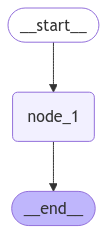

In [9]:
graph

# Let's define a reducer

In [16]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: Annotated[str, operator.add]

def node_1(state):
    return {"message": " james!"}

In [19]:
graph_builder = StateGraph(MyState)

graph_builder.add_node("node_1", node_1)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", END)

graph = graph_builder.compile()

In [20]:
graph.invoke({"message": "hi"})

{'message': 'hi james!'}

# Let's add a conditional edge

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: Annotated[str, operator.add]

def node_1(state):
    return {"message": " james!"}

def node_2(state):
    return {"message": " how are you?"}

def node_3(state):
    return {"message": " it's all ok?"}

In [32]:
from random import random
from typing import Literal

def take_a_path(state) -> Literal["node_2", "node_3"]:
    if random() < 0.5:
        return "node_2"
    
    return "node_3"


graph_builder = StateGraph(MyState)

graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_conditional_edges("node_1", take_a_path) #  {"node_2": "node_2", "node_3": "node_3"}
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

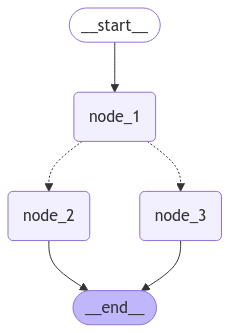

In [33]:
graph

In [40]:
graph.invoke({"message": "hi"})

{'message': 'hi james! how are you?'}

# Let's build a basic chatbot

In [42]:
from dotenv import load_dotenv

load_dotenv()

True

In [43]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [46]:
class ChatbotState(TypedDict):
    user_request: str
    answer: str

def chatbot(state):
    user_request = state["user_request"]
    ai_answer = llm.invoke([("user", user_request)])

    return {"answer": ai_answer.content}


graph_builder = StateGraph(ChatbotState)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [47]:
graph.invoke({"user_request": "hi!"})

{'user_request': 'hi!', 'answer': 'Hello! How can I assist you today?'}

# Let's use a better state

In [49]:
from langgraph.graph.message import add_messages, MessagesState

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state):
    ai_answer = llm.invoke(state["messages"])

    return {"messages": [ai_answer]}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [51]:
graph.invoke({"messages": [("user", "hi!")]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='ff32acdc-8bbe-407f-81fe-9ad0979b76f9'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-24ea0f1c-cb3f-4a21-b19d-023ecf88b4ac-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}